In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pylab as plt
import operator
from sklearn.metrics import mutual_info_score
pd.set_option('display.width', 2000)

In [3]:
sys.version

'3.6.6 (default, Jul 19 2018, 14:25:17) \n[GCC 8.1.1 20180712 (Red Hat 8.1.1-5)]'

1. basics - exploratory work etc.
2. featurize - write script to do MI work automatically and keep floats unchanged
3. first model - combine all features into a single model + calibration with Kaggle
4. hyperparameter tuning + k-fold - tune a few features. examples of grid search
5. Model introspection - look for wrong predictions, turn into classification problem
6. alternate models - logistic regression, SVMs, NN (pytorch - fully connected)
7. ensembling
8. final notes


# Read Data

In [4]:
#read data
data = pd.read_csv('data/MS/train.csv')

/home/sanjay/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#(nrows, ncols)
data.shape

(8921483, 83)

In [6]:
#first 10 rows
data.head(10)

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1
5,000016191b897145d069102325cab760,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1094.0,0,7.0,0,NaN,53447.0,...,51039.0,0,0.0,0.0,0,0,0.0,0.0,15.0,1
6,0000161e8abf8d8b89c5ab8787fd712b,win8defender,1.1.15100.1,4.18.1807.18075,1.273.845.0,0,7.0,0,NaN,43927.0,...,63175.0,1,NaN,0.0,0,0,0.0,0.0,10.0,1
7,000019515bc8f95851aff6de873405e8,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1393.0,0,7.0,0,NaN,53447.0,...,63122.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
8,00001a027a0ab970c408182df8484fce,win8defender,1.1.15200.1,4.18.1807.18075,1.275.988.0,0,7.0,0,NaN,53447.0,...,15510.0,0,0.0,0.0,0,0,0.0,0.0,15.0,0
9,00001a18d69bb60bda9779408dcf02ac,win8defender,1.1.15100.1,4.18.1807.18075,1.273.973.0,0,7.0,0,NaN,46413.0,...,63555.0,1,0.0,0.0,0,0,0.0,1.0,8.0,1


In [7]:
#access column's first 10 rows
data['MachineIdentifier'].head(10)

0    0000028988387b115f69f31a3bf04f09
1    000007535c3f730efa9ea0b7ef1bd645
2    000007905a28d863f6d0d597892cd692
3    00000b11598a75ea8ba1beea8459149f
4    000014a5f00daa18e76b81417eeb99fc
5    000016191b897145d069102325cab760
6    0000161e8abf8d8b89c5ab8787fd712b
7    000019515bc8f95851aff6de873405e8
8    00001a027a0ab970c408182df8484fce
9    00001a18d69bb60bda9779408dcf02ac
Name: MachineIdentifier, dtype: object

In [8]:
#number of unique values for each column
for col in data.columns:
    print(f'{col} : {len(data[col].unique())}')

MachineIdentifier : 8921483
ProductName : 6
EngineVersion : 70
AppVersion : 110
AvSigVersion : 8531
IsBeta : 2
RtpStateBitfield : 8
IsSxsPassiveMode : 2
DefaultBrowsersIdentifier : 2018
AVProductStatesIdentifier : 28971
AVProductsInstalled : 9
AVProductsEnabled : 7
HasTpm : 2
CountryIdentifier : 222
CityIdentifier : 107367
OrganizationIdentifier : 50
GeoNameIdentifier : 293
LocaleEnglishNameIdentifier : 276
Platform : 4
Processor : 3
OsVer : 58
OsBuild : 76
OsSuite : 14
OsPlatformSubRelease : 9
OsBuildLab : 664
SkuEdition : 8
IsProtected : 3
AutoSampleOptIn : 2
PuaMode : 3
SMode : 3
IeVerIdentifier : 304
SmartScreen : 22
Firewall : 3
UacLuaenable : 12
Census_MDC2FormFactor : 13
Census_DeviceFamily : 3
Census_OEMNameIdentifier : 3833
Census_OEMModelIdentifier : 175366
Census_ProcessorCoreCount : 46
Census_ProcessorManufacturerIdentifier : 8
Census_ProcessorModelIdentifier : 3429
Census_ProcessorClass : 4
Census_PrimaryDiskTotalCapacity : 5736
Census_PrimaryDiskTypeName : 5
Census_System

Notes:

   * No time-stamps - technically, one would expect a sequence of events before a machine is infected but this is data is a flat snapshot.
    
   * MachineIdentifier - primary key/index
    
   * HasDetections - binary target to predict (0 - not infected, 1 - infected) 

In [9]:
#Distribution of target
data['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

**Labels have an even distributions (~50-50%)**

The column we are predicting is often called the "label" or the "target". Targets can be of many kinds:

1. Real (float) values - such machine learning problems are called **regression** problems. Examples - predict the value of homes based on neighborhood and macroeconomic quantities, predict the angle through which a steering wheel should be turned on a self-driving car based on environment inputs.

2. Discrete values - these problems are called **classification** problems. In this case, we have two labels - 0 or 1. A key distinction from regression is that while numerically 1 > 0, in terms of class there's no meaning to the statement class 1 > class 0 and this has to get reflected in the type of model chosen. If there are two classes or categories to be predicted, the problems are often called **binary classfication** problems as opposed to **multi-class classification** problems consisting of > 2 categories. Examples - is a check fake or not based on the image, image labels based on pixels.

For binary classification problems, a concern is the balance of the two labels i.e.the % of rows with 0s with 1s. If they are roughly equally distributed, then there's no problem. But what if they are not? Let's look at an extreme example.

For many (supervised) anomaly/outlier detection problems (target = 0 is normal, target = 1 is anomalous), most of the dataset consists of 0s with very few 1s. For example - maybe 98% of the rows are normal and 2% are anomalous. Why is this a problem? Suppose we build/train a model that predicts whether a data-point (row) is normal or anomalous. But we decide to cheat - our "model" predicts every row is normal (0). What would the accuracy of such a model be?

Correct - we got all the target = 0 (98%) predictions right.

Incorrect - we got all the target = 1 (2%) predictions wrong.

So, our accuracy is 98% which sounds great but we didn't really learn the ability to predict the anomalies!!!

There are some common remedies to this *class imbalance* problem:

1. Use a different metric:

Instead of accuracy, use area under curve (see below) or look at the confusion matrix, or precision/recall curves which are all sensitive to the problem described above.

2. Resampling: 

Take all the anomalous rows and randomly sample as many rows from the normal rows. While this leads to a 50-50% label split, we dramatically reduced the size of our dataset (4% of the original). A workaround for the small dataset size is to do this procedure multiple times and train a model on each instance. The outputs from all the models is then combined in a meta-model which often leads to much better results.

Another approach is to keep the normal rows but sample with replacement from the anomalous rows. This will lead to a 50-50% split with each anomalous row repeated several times.

As with many aspects of practical machine learning, there's no procedure. What you pick depends on the problem, how various modeling techniques work, as well as sometimes just trial and error with careful checking.

3. Resampling by weights:

A very elegant approach is to apply a weight of 1 to each normal row but a much higher weight (49 = 98/2) to each anomalous row. What does this mean? Most machine learning algorithms can be recast as optimization problems where:

$C = \Sigma_{i=1}^n C[i]$

is some *cost* that is to be minimized. Each $C[i]$ is 0 when the prediction for the $i^{th}$ point agrees with the label and is high when it doesn't.

This can be modified to:

$C = \Sigma_{i=1}^n w(i) C[i]$

where $w(i)$ is a weight that is 1 for the large class (normal) and high for the small class (anomalous).

Suppose we have a simple cost function: if the prediction for the ith row is correct, $C[i] = 0$ and if it's wrong, $C[i] = 1$. Without the weights, whether we get an anomalous row prediction incorrect or a normal row prediction incorrect, our cost increases by 1.

But with the weights, if we get a normal row prediction incorrect, the cost increases by 1 but if we get an anomalous row prediction incorrect, it increases by $w(i)$ (49 in this case). This forces the algorithm to try and get the anomalous predictions correct too instead of ignoring them and focusing on the majority class of normal rows.

**Note on probabilities by scores**

For classification problems, most algorithms predict a number (**score**) between 0 and 1. It is very tempting to treat these as probabilities of belonging to target = 1 but this is often incorrect.

One way to use these scores is to use them as they are and pick a threshold (see AUC below) t, such that a score > t signifies a prediction of 1 and a score <= t signifies a prediction of 0.

In some applications though, we want to intepret the score as a probability. The act of transforming scores to probabilities is called *probability calibration*.

One scenario where this occurs is precisely the resampling mentioned above. 

# Measuring model performance

The metric we use for this competition is "Area under ROV curve" (AUC = area under curve). This is a number between 0 and 1 where

AUC = 0.5 -> random guesses for HasDetections

AUC = 1.0 -> perfect predictions

The core idea is very simple. Suppose we have a binary classification problem with labels = 0 or 1. We build a model that predicts a score between 0 and 1 and based on some threshold, t, we want to make a hard prediction for each row. More precisely, if the score > t -> prediction = 1 and if the score <= t -> prediction = 0.

What t should we pick? Before answering this question, let's define a **confusion matrix**.

Given a picked threshold t, we can make a prediction 0/1 for each row with labels 0/1. This lets us write a matrix

INSERT MATERIAL

# Validation

We cannot just build a model on the train set and submit it. This usually results in overfitting i.e. a model memorizing answers instead of understanding statistical features and their relation to the output.

To guard against this, a usual practice is cross-validation.

We'll use a few common approaches:

**Simple splits**:

Split the data into a "train" set and a hold-out "test" set - maybe 60% is train and 40% is test. The model will be trained on the 60% and applied to the 40%. Since we know the labels (HasDetections) on both sets, we can evaluate how well we did.

**Validation set**:

The above approach has a problem. Often machine learning models have so-called hyperparameters i.e. parameters that are not optimized during fitting. Examples: linear regression with regularization - regularization strength, decision trees - tree depth (among others), neural networks - number of hidden layers, number of nodes in each layer, activation functions etc. In the process of finding

We want to find the best possible model where "best" denotes the model with the highest AUC on the test set.

How would one go about this? The straighforward approach is as follows:

1. Pick a model class - say, random forests.
2. Build the model on the train set and calculate the **test AUC** by applying it to the **test** set.
3. Tweak the hyperparameters (say, number of trees) and repeat step 2 till **find maximum test AUC**.

While this approach sounds reasonable, it'll also lead to overfitting. In particular, information about the test set "leaks" into the training process and the leaker is **us**! By looking at the test AUC, we make the decision to change the hyperparameter in the new model that is trained on the train set.

So one will end up with excellent performance on the test set but when new data comes in, the model might suffer a drop in performance.

**Golden Rule:** No information about the test set should ever touch the training process. This is called *leakage*.

A common work-around this problem is to split the data into *3* pieces - 

**Train** set - data that the model is trained on

**Validation** set - data to which model is applied to tune the hyperparameters

**Test** set - once the final model (with the final hyperparameters) is picked, it is applied to the test set to really test performance

**k-fold Cross Validation**:

A problem with creating the validation set is that the data used for training might be severely diminished. For examples, maybe we'll choose train to be 60%, validation to be 20% and test to be 20% of the full data. Ideally, we would like to train with as much data as possible to get statistically accurate estimation of our model parameters.

A work-around this problem is **k-fold cross-validation**.

The idea is simple:

1. Split the data into k equal pieces.

2. Hold one of the pieces out and train on the remaining k-1 pieces.

3. Evaluate the performance (AUC) on the 1 piece left out.

For each piece that's left out, we'll have one AUC to give k AUCs. The final AUC is the average of these k AUCs.

The advantage of this approach is that we don't need a validation set and we can use more data for training. The major disadvantage is that one now needs k training loops instead of just 1.

**WARNING**: The data should be shuffled (and sklearn takes care of that) for all these splitting strategies. It is crucial to have randomly selected data in each set which results in the same probability distributions of the features in each set.

Example: we don't want to build a model to control airplane surfaces based on calm wind conditions (train set) and apply it in turbulent situations (test set). Randomization ensures that both train and test have the same mix of calm and turbulent conditions.

INSERT NOTE ABOUT TIME-SERIES VALIDATION

In [10]:
#Rough exploratory analysis
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size=0.60)

#convert to pandas dataframes
train = pd.DataFrame(train, columns=data.columns)
test = pd.DataFrame(test, columns=data.columns)

/usr/local/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


KeyboardInterrupt: 

In [19]:
#persist dataframes so don't need to re-run splitting each time
train.to_csv('data/cv_train.csv', index=False)
test.to_csv('data/cv_test.csv', index=False)

In [4]:
train = pd.read_csv('data/cv_train.csv')
test = pd.read_csv('data/cv_test.csv')

/home/sanjay/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print('Train:', train.shape)
print('Test :', test.shape)

Train: (5352889, 83)
Test : (3568594, 83)


In [6]:
train.iloc[0]

MachineIdentifier                                  16616b4d3b230f626e7b80be72994eb3
ProductName                                                            win8defender
EngineVersion                                                           1.1.15200.1
AppVersion                                                          4.18.1807.18075
AvSigVersion                                                            1.275.727.0
IsBeta                                                                            0
RtpStateBitfield                                                                  7
IsSxsPassiveMode                                                                  0
DefaultBrowsersIdentifier                                                       NaN
AVProductStatesIdentifier                                                     53447
AVProductsInstalled                                                               1
AVProductsEnabled                                                           

# Exploratory Models

Our goal is to predict the column 'HasDetections' with the highest possible accuracy.

This is where 'domain knowledge' comes in. Depending on the problem, various factors and their combinations might be most meaningful. For example, while a physicist and a financial trader might both be using random forests, the input data/features will usually be hand-crafted by each one based on his/her understanding of the problem they are solving.

Having said that, statistics and machine learning models are not useful just for predicting. They can be used to gain **insight** into the data itself. We'll now start on the first leg of our journey to both predict 'HasDetections' and extract insights about what the markers for an intrusion are.

### Mutual information

We won't go into the details and derivation of mutual information here. For the purpose of this workshop, you can treat mutual information (MI) as a measure of correlation between categorical variables. Given two columns A and B, MI(A,B)=0 -> they are uncorrelated i.e. knowing the value of A says nothing about the value of B and vice-versa. A high MI(A, B) implies that knowing the value of A tells us a lot about the value of B and vice-versa.

In [15]:
mutual_info_score(train['SMode'], train['HasDetections'])

0.04196236673107308

In [84]:
mi_scores = {} #mutual information scores between columns and target
for col in train:
    
    try:
        score = mutual_info_score(train[col].astype(str).fillna('null'), train['HasDetections']) #MI(col, target)
        N_unique = len(train[col].unique()) #number of unique elements in col
        N_nan = np.sum(train[col].isnull())/float(train.shape[0]) #% of values that are nulls in col
    
        mi_scores[col] = (score, N_unique, N_nan)
        
    except:
        print(f'Error with col = {col}')

In [85]:
#INSERT DEBUG THESE COLS - mixed types
mi_scores['MachineIdentifier']

(0.6931470846023761, 5352889, 0.0)

In [86]:
#sort in decreasing order by MI(col, HasDetections)
for element in sorted(mi_scores.items(), key=operator.itemgetter(1, 0), reverse=True):
    print('{:50} : {:22} : {:8} : {}'.format(element[0], element[1][0], element[1][1], element[1][2]))

HasDetections                                      :     0.6931470846023765 :        2 : 0.0
MachineIdentifier                                  :     0.6931470846023761 :  5352889 : 0.0
Census_SystemVolumeTotalCapacity                   :    0.06301806463296625 :   454043 : 0.005971354907602231
Census_OEMModelIdentifier                          :    0.02923570951963776 :   139304 : 0.011482958081140858
SmartScreen                                        :    0.02816486570974574 :       20 : 0.35608416315002983
AVProductStatesIdentifier                          :   0.023580225821684918 :    21672 : 0.004076677099039416
CityIdentifier                                     :   0.015660346942019124 :    93099 : 0.03654157596019645
Census_FirmwareVersionIdentifier                   :   0.012972551805742525 :    44979 : 0.017961702549781997
AvSigVersion                                       :    0.01191353919909979 :     8401 : 0.0
AVProductsInstalled                                :   0.011540

In [24]:
#def mi_score(df, c1, c2):
del mi_scores
del data
import gc
gc.collect()

837

# Simple 1-feature models

Another way to get intuition about individual columns is by building models that use a *single* feature to predict the output. This will also serve as an introduction to preprocessing and feature engineering. 

A lot of the work below looks inelegant from a programming perspective. But, while this approach is not scalable to datasets with a large number columns, it often gives a lot of intuition to the data scientist.

In [56]:
#we'll use random forests as a reference model since they need minimal preprocessing
#and are flexible non-linear learners

from sklearn.ensemble import RandomForestClassifier

In [58]:
#AUC scoring function

from sklearn.metrics import roc_auc_score

In [27]:
for col in train.columns:
    print(col)

MachineIdentifier
ProductName
EngineVersion
AppVersion
AvSigVersion
IsBeta
RtpStateBitfield
IsSxsPassiveMode
DefaultBrowsersIdentifier
AVProductStatesIdentifier
AVProductsInstalled
AVProductsEnabled
HasTpm
CountryIdentifier
CityIdentifier
OrganizationIdentifier
GeoNameIdentifier
LocaleEnglishNameIdentifier
Platform
Processor
OsVer
OsBuild
OsSuite
OsPlatformSubRelease
OsBuildLab
SkuEdition
IsProtected
AutoSampleOptIn
PuaMode
SMode
IeVerIdentifier
SmartScreen
Firewall
UacLuaenable
Census_MDC2FormFactor
Census_DeviceFamily
Census_OEMNameIdentifier
Census_OEMModelIdentifier
Census_ProcessorCoreCount
Census_ProcessorManufacturerIdentifier
Census_ProcessorModelIdentifier
Census_ProcessorClass
Census_PrimaryDiskTotalCapacity
Census_PrimaryDiskTypeName
Census_SystemVolumeTotalCapacity
Census_HasOpticalDiskDrive
Census_TotalPhysicalRAM
Census_ChassisTypeName
Census_InternalPrimaryDiagonalDisplaySizeInInches
Census_InternalPrimaryDisplayResolutionHorizontal
Census_InternalPrimaryDisplayResolutio

# Col = MachineIdentifier - index col - unique for each row - not useful for predictions

# Col = ProductName (MI = ~6 * 10^-6)

In [28]:
train['ProductName'].value_counts()

win8defender     5295870
mse                56962
mseprerelease         34
scep                  13
fep                    5
windowsintune          5
Name: ProductName, dtype: int64

### 1-hot encoding

The data in a single column we'll usually see will be one of 3 types:

1. float - the value matters and there's an ordering implied. E.g. 5 apples > 3 apples

2. Discrete (int) - the values are discrete but there's an ordering

3. Categorical (int/str) - the values are discrete but there's no ordering implied. E.g. OS = 'Windows' or OS = 'Linux' - one can't compare the two values numerically and there's no ordering Linux > Windows or Windows > Linux (well there IS but mathematically there isn't one)

As an example consider 'ProductName' with possible values - 'win8defender', 'mse', 'scep' etc.

One could do a group-by this column and get the % of 1s vs 0s in the target variable. But eventually, we'll have several such variables in combination with columns of type 1. and 2. above. So we need a better approach.

A commonly used approach is the so-called **one-hot encoding**. The idea is very simple and best illustrated by an example. Suppose we have a column 'X' with 3 unique values in 5 rows:

'apple'

'mango'

'banana'

'banana'

'mango'

We want to convert these to numbers so our statistical techniques can perform mathematical operations and learn something useful. In one-hot encoding, we simply create one column for each unique value and use booleans:

'apple' -> [1, 0, 0]

'mango' -> [0, 1, 0]

'banana' -> [0, 0, 1]

'banana' -> [0, 0, 1]

'mango' -> [0, 1, 0]

Two points:

1. Why can't we just map 'apple' -> 0, 'mango' -> 1, 'banana' -> 2. Because then we are imposing an implicit ordering - banana > mango > apple which we don't want to impose on our models.

2. If there are N unique values in the column, we create N columns. Clearly, there's a much more compact representation as bit strings of len $\log_2(N)$. Why not use that with exponentially less memory usage? The answer here is that we want to not have any interactions between the columns we create. For e.g. by looking at the apple column and seeing a 1, a model shouldn't have to look at any other columns to deduce that the value is indeed 'apple'. This wouldn't be true with the more compact representation.

In [29]:
#two ways to 1-hot encode

pd.get_dummies(train['ProductName'].head(20), prefix='ProductName') #prefix gets prepended before column name

,ProductName_mse,ProductName_win8defender
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,1,0


In [30]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()

one_hot.fit_transform(train[['ProductName']].head(20)).todense()

matrix([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [31]:
one_hot.transform(train[(train['ProductName']!='win8defender') & (train['ProductName']!='mse')][['ProductName']].head(20))

ValueError: Found unknown categories ['mseprerelease', 'scep', 'fep', 'windowsintune'] in column 0 during transform

### Problem with one-hot encoding

The above error highlights a problem. What if the train set has 3 unique values for a column but the test has a fourth one? This will result in a problem since the shapes of the datasets for train and test will be different and the model expects a certain shape and a certain ordering of columns.

One solution to this is to do one-hot encoding on the full dataset before splitting into train and test or to ensure that train and test have the same unique values.

In [10]:
def check_train_test_1hot(train, test, colname):
    train_vals = set(train[colname].unique())
    test_vals = set(test[colname].unique())
    
    intersection = train_vals.intersection(test_vals)
    union = train_vals.intersection(test_vals)
    
    if len(union) != len(intersection):
        return False

    return True

In [11]:
colname = 'ProductName'

assert(check_train_test_1hot(train, test, colname))

In [12]:
train_df = pd.get_dummies(train[[colname]], dummy_na=True)
test_df = pd.get_dummies(test[[colname]], dummy_na=True)

In [13]:
train_df.head()

,ProductName_fep,ProductName_mse,ProductName_mseprerelease,ProductName_scep,ProductName_win8defender,ProductName_windowsintune,ProductName_nan
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [14]:
test_df.head()

,ProductName_fep,ProductName_mse,ProductName_mseprerelease,ProductName_scep,ProductName_win8defender,ProductName_windowsintune,ProductName_nan
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [37]:
#Let's train our first model!!!

#select model type and fit - ensure train_df doesn't have 'HasDetections'

assert('HasDetections' not in train_df)
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

#predict probabilities of belong to class 1
train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

#actual values
train_labels = train['HasDetections']
test_labels = test['HasDetections']

#compute AUC for train and test score
train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'col = {col} : train_score = {train_score} : test_score = {test_score}')

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


col = HasDetections : train_score = 0.5003258436674305 : test_score = 0.500329960964148


As one can see, ProductName gives an AUC of 0.5 which is the same as guessing by chance. We expect this since the mutual information betwen ProductName and HasDetections is ~ 10^-6. Another way to see this is by looking at the % of 1s vs 0s for each distinct product type

In [38]:
train.groupby(['ProductName', 'HasDetections']).count()['MachineIdentifier']

ProductName    HasDetections
fep            0                      3
               1                      2
mse            0                  29356
               1                  27606
mseprerelease  0                     21
               1                     13
scep           0                      9
               1                      4
win8defender   0                2648223
               1                2647647
windowsintune  0                      5
Name: MachineIdentifier, dtype: int64

For the statistically large classes, the values are ~50-50% which implies that knowing ProductName's value has no bearing on HasDetections.

# col = EngineVersion (MI = 8 * 10^-3)

In [42]:
train['EngineVersion'].value_counts()

1.1.15200.1    2307649
1.1.15100.1    2205121
1.1.15000.2     159123
1.1.14901.4     127026
1.1.14600.4      96564
1.1.14800.3      82031
1.1.15300.6      72123
1.1.14104.0      56453
1.1.13504.0      42605
1.1.15300.5      41134
1.1.14700.5      28160
1.1.14500.5      27255
1.1.14405.2      21674
1.1.14306.0      14392
1.1.14202.0       9189
1.1.14003.0       8694
1.1.13903.0       5880
1.1.13804.0       5674
1.1.13303.0       5612
1.1.13407.0       5313
1.1.13601.0       4313
1.1.12902.0       3198
1.1.14305.0       3037
1.1.13701.0       2976
1.1.13704.0       2896
1.1.13202.0       2826
1.1.13103.0       2581
1.1.13000.0       2451
1.1.12805.0       1521
1.1.15000.1       1496
                ...   
1.1.14002.0         48
1.1.11701.0         48
1.1.12101.0         46
1.1.14103.0         45
1.1.13902.0         42
1.1.14102.0         38
1.1.14001.0         28
1.1.13802.0         25
1.1.12400.0         23
1.1.13803.0         15
1.1.13406.0         14
1.1.12603.0         11
1.1.12706.0

EngineVersion consist of version strings that encode version numbers. What are our options?

**One-hot encoding**: this would result in 67 columns (one for each unique value)

**Observations**:
1. Most of the values are distributed among ~10 values with a long tail of values with <100 occurrences.
2. There's probably an implicit time ordering here. The version numbers increase with time. In particular, if there's a regular release cycle, we can actually impute when malware was detected within $\pm\Delta \text{release cycle time}$. Ignore this time for now but think of how we can exploit this fact.

Let's explore this column in more detail

(array([65.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([1.0000000e+00, 2.3076580e+05, 4.6153060e+05, 6.9229540e+05,
        9.2306020e+05, 1.1538250e+06, 1.3845898e+06, 1.6153546e+06,
        1.8461194e+06, 2.0768842e+06, 2.3076490e+06]),
 <a list of 10 Patch objects>)

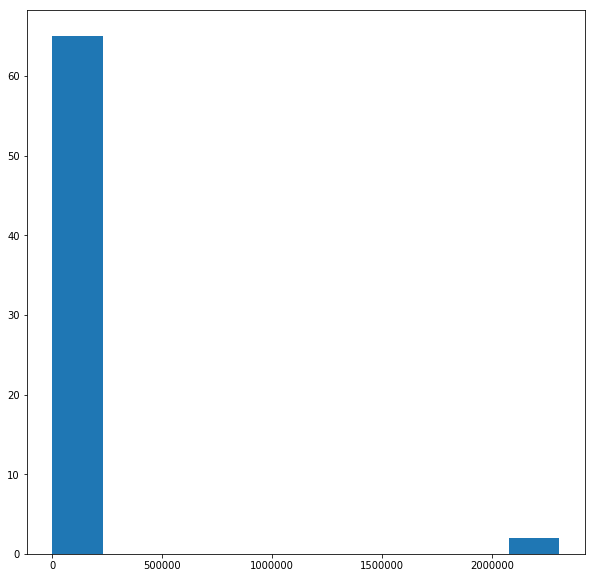

In [43]:
#histogram of value counts
plt.figure(figsize=(10,10))
plt.hist(train['EngineVersion'].value_counts())

In [44]:
#a few (2) columns dominate the counts

value_counts = train['EngineVersion'].value_counts()

print("% of values with top 2 values: ", value_counts[0:2].sum() / float(value_counts.sum())) #% of counts with top 2 values

% of values with top 2 values:  0.8430531625071994


(array([54.,  3.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([1.000000e+00, 1.591320e+04, 3.182540e+04, 4.773760e+04,
        6.364980e+04, 7.956200e+04, 9.547420e+04, 1.113864e+05,
        1.272986e+05, 1.432108e+05, 1.591230e+05]),
 <a list of 10 Patch objects>)

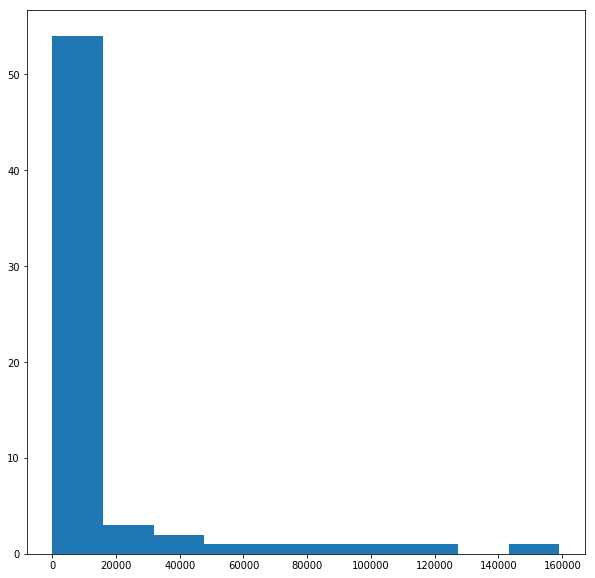

In [45]:
plt.figure(figsize=(10,10))
plt.hist(value_counts[2:])

Out of 67 unique values:

~84% of the rows have only one of two values
54 unique values each have < 20,000 rows

One possibility is to combine the tail into one new value

Let's plot the value counts as a time-series to look at which version occur most often

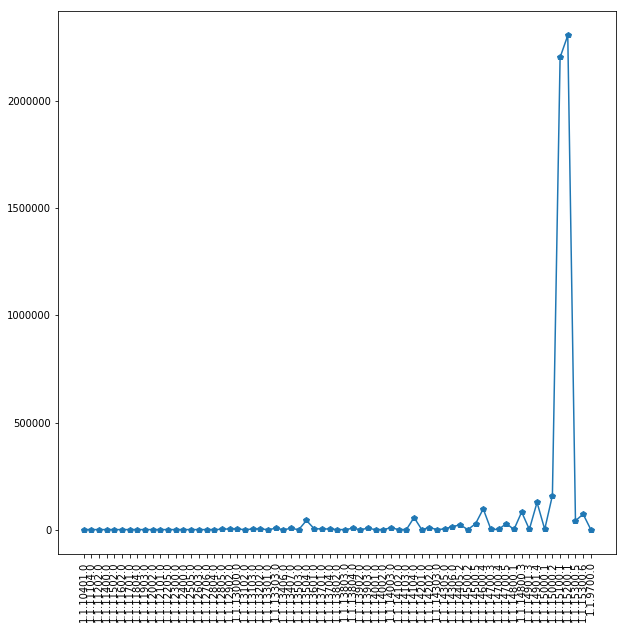

In [46]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.plot(value_counts.sort_index(), 'p-')
#plt.yscale('log')
#plt.title("NOTE LOG SCALE")

All the values are of the form "1.1.X". Let's strip out the "1.1" for convenience

In [47]:
value_counts.index = [i.split('1.1.')[1] for i in value_counts.index]

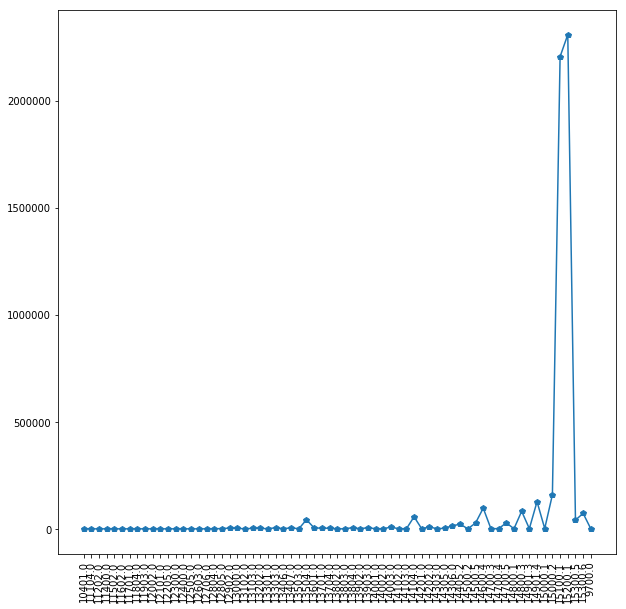

In [48]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.plot(value_counts.sort_index(), 'p-')
#plt.yscale('log')
#plt.title("NOTE LOG SCALE")

As before, we want to explore the power of "EngineVersion" to predict HasDetections. We'll explore 3 ways (2 have already been used before).

1. Group bys: Groupby the column of interest and the target column and see if there's a departure from the balance of 50-50% in the target within each group.

In [49]:
print("Two dominant classes: ")
train[train['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])].groupby(['EngineVersion', 'HasDetections']).count()['MachineIdentifier']

Two dominant classes: 


EngineVersion  HasDetections
1.1.15100.1    0                 985882
               1                1219239
1.1.15200.1    0                1173611
               1                1134038
Name: MachineIdentifier, dtype: int64

This is good news! Overall in the data, we have #HasDetections=1 / #HasDetections=0 = 0.999 ~ 1 i.e. there are as many 0s as 1s.

But within the subset of data with EngineVersion == 1.1.15100.1, we have a ratio of 1.23
and within the subset of data with EngineVersion == 1.1.15200.1, we have a ratio of 0.96

This asymmetry will help us when we build a model. But what about the non-dominant values for EngineVersion. Let's group them all into one category.

In [50]:
train[~train['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])].groupby(['HasDetections']).count()['MachineIdentifier']

HasDetections
0    518124
1    321995
Name: MachineIdentifier, dtype: int64

Here, we get a ratio 

#HasDetections=1 / #HasDetections=0 = 0.62 

This is excellent news. This class of the tail of EngineVersions has a significant departure from the 1:1 ratio. Let's proceed to the other two steps to understand how strong EngineVersion is.

2. Mutual information

In [51]:
mutual_info_score(train['HasDetections'], train['EngineVersion'])

0.008227876480825

3. Simple 1-factor model

In [52]:
train_df = train[['EngineVersion']].copy()
test_df = test[['EngineVersion']].copy()

In [53]:
train_df[~train_df['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])] = 'rest'
test_df[~test_df['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])] = 'rest'

In [54]:
train_df = pd.get_dummies(train_df[['EngineVersion']], dummy_na=True)
test_df = pd.get_dummies(test_df[['EngineVersion']], dummy_na=True)

In [60]:
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'train_score = {train_score} : test_score = {test_score}')

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.5584103493439923 : test_score = 0.5581229859804917


Ah! much better - we get an AUC = ~0.56 which is better than chance as we expected given the asymmetries in the groupbys.

A natural question is wondering whether we should have not grouped everything except the top-2 classes together but had a different arrangement.

Let's tackle that question using mutual information.

3. Mutual information

In [61]:
print("Mutual information between EngineVersion and HasDetections: ", mutual_info_score(train['EngineVersion'], train['HasDetections']))

Mutual information between EngineVersion and HasDetections:  0.008227876480824993


Let's now rank EngineVersion values by how many times they occur (value_counts) and group all the elements from index i to the last one together and see how mutual information is impacted

In [62]:
value_counts = train['EngineVersion'].value_counts()

mi_values = {}
for i in range(2, 60): #combine [i, last] -> one category
    train_df = train[['EngineVersion']].copy()

    top_values = list(value_counts[0:i].index)

    train_df[~train_df['EngineVersion'].isin(top_values)] = 'rest'

    mi_values[i] = mutual_info_score(train_df['EngineVersion'], train['HasDetections'])

In [63]:
sorted(mi_values.items(), key=operator.itemgetter(1), reverse=True)

[(59, 0.008227065267823287),
 (58, 0.008227065267823283),
 (57, 0.008227058512233688),
 (56, 0.00822705798090321),
 (55, 0.008227057647860003),
 (54, 0.0082268558242503),
 (53, 0.008226786058068456),
 (52, 0.008226780179606728),
 (51, 0.008226723020557887),
 (50, 0.008226704346894863),
 (49, 0.008226690499618466),
 (48, 0.00822668518185769),
 (47, 0.00822658141544121),
 (46, 0.008226573201419368),
 (45, 0.008226515155887603),
 (44, 0.00822648335061588),
 (43, 0.008226081336286904),
 (42, 0.008225882437770423),
 (41, 0.00822571874529524),
 (40, 0.008225183229691723),
 (39, 0.008223528943518568),
 (38, 0.00822261448879368),
 (37, 0.00822258764289043),
 (36, 0.00822234115649246),
 (35, 0.008222287780524626),
 (34, 0.008221984256597432),
 (33, 0.008221632678918617),
 (32, 0.008220927932721575),
 (31, 0.008220908571890149),
 (30, 0.008220762316962863),
 (29, 0.008219354836915091),
 (28, 0.008216856819915117),
 (27, 0.008216363015051084),
 (26, 0.00821595803109123),
 (25, 0.00821592698918595

The values saturate to around ~0.0082 once we combine all the values from index 10 onwards (incl. 10)

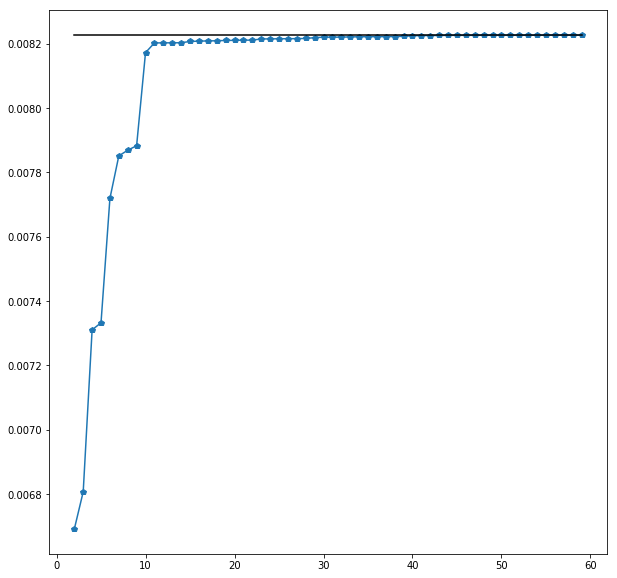

In [64]:
plt.figure(figsize=(10,10))
plt.plot(mi_values.keys(), mi_values.values(), 'p-')
plt.plot(mi_values.keys(), [mutual_info_score(train['EngineVersion'], train['HasDetections'])]*len(mi_values), color='black')

What this plots tells us is that mutual information goes up in drastic steps till we merge all the values from the 10th onwards into a single category. At that stage, we gain nothing more by adding more categories. So, let's do that!!

In [54]:
train_df = train[['EngineVersion']].copy()
test_df = test[['EngineVersion']].copy()

top_values = list(value_counts[0:11].index)

train_df[~train_df['EngineVersion'].isin(top_values)] = 'rest'
test_df[~test_df['EngineVersion'].isin(top_values)] = 'rest'

train_df = pd.get_dummies(train_df[['EngineVersion']], dummy_na=True)
test_df = pd.get_dummies(test_df[['EngineVersion']], dummy_na=True)

In [55]:
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'col = {col} : train_score = {train_score} : test_score = {test_score}')

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


col = HasDetections : train_score = 0.560734100549694 : test_score = 0.5604783682073644


We get a marginal improvement in our test score from:

0.5581229859804917 -> 0.5604804598167951

(improvement of 0.42%) but from just one feature and from ensuring we don't throw away too much information by combining all except the top 2 values.

**Note about cross-validation**:

I have been implicitly looking at both train and test scores each time we fit a model. The idea is that they should be comparable. If the train score is far better (higher in the case of AUC) than the test score, then we are overfitting i.e. our model is memorizing the train set, doing very well on it but fails when new data comes in.

We are not doing *hyperparameter tuning* yet i.e. we initialize our model as:

model = RandomForestClassifier()

which uses the default values for all arguments. Eventually, we'll want to vary those arguments to maximize *both* train and test scores till they start diverging. The idea is that with default values, both scores might be pretty low. As we tune or vary them, both scores might improve but if train score improves far more than test score, then we know we are overfitting and we need to undo the change.

A common question is: what if the test score is **better** than the train score. This is a fluke! Don't rely on your model to do that systematically. One always wants control over the model i.e. by ensuring that performance on train and test is almost the same.

Once we do K-fold cross-validation, this will be even easier to see. We'll have K test scores (one for each fold) and we can look at their variance to get a sense of the effect of randomized dataset selection on our model (at the cost of training many more models).

# col = AppVersion (MI = 5.6*10^-3)

Now we want to repeat a lot of the work that we did with EngineVersion and this is a good chance to consolidate all our work above.

In [29]:
train['AppVersion'].value_counts()

4.18.1807.18075     3082514
4.18.1806.18062      510575
4.12.16299.15        216287
4.10.209.0           163695
4.13.17134.1         154505
4.16.17656.18052     140966
4.13.17134.228       136031
4.8.10240.17443      123102
4.9.10586.1106       121868
4.14.17639.18041     116919
4.12.17007.18022      71002
4.9.10586.0           67076
4.11.15063.447        55086
4.10.14393.0          46409
4.11.15063.0          41662
4.12.17007.18011      36834
4.14.17613.18039      31806
4.8.10240.16384       27395
4.11.15063.1155       26719
4.10.14393.1794       26441
4.9.10586.494         14857
4.10.14393.1198       14221
4.9.10586.672         13457
4.13.17134.191        12309
4.12.17007.17123       8238
4.18.1809.2            8197
4.10.14393.1613        8130
4.9.10586.589          7994
4.13.17134.112         7668
4.9.10586.1045         6248
                     ...   
4.17.17682.1000          34
4.15.17666.1000          30
4.9.10586.456            27
4.18.1806.20033          21
4.9.10586.1177      

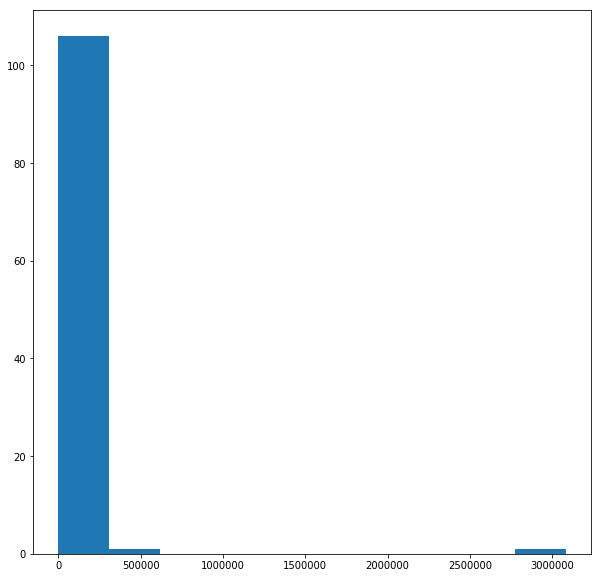

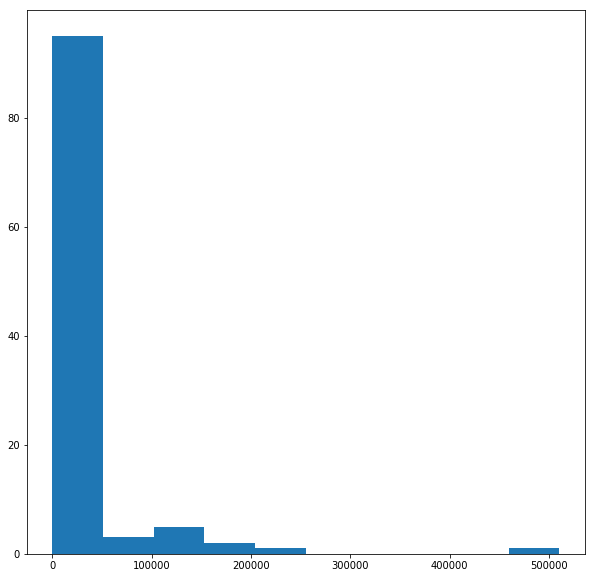

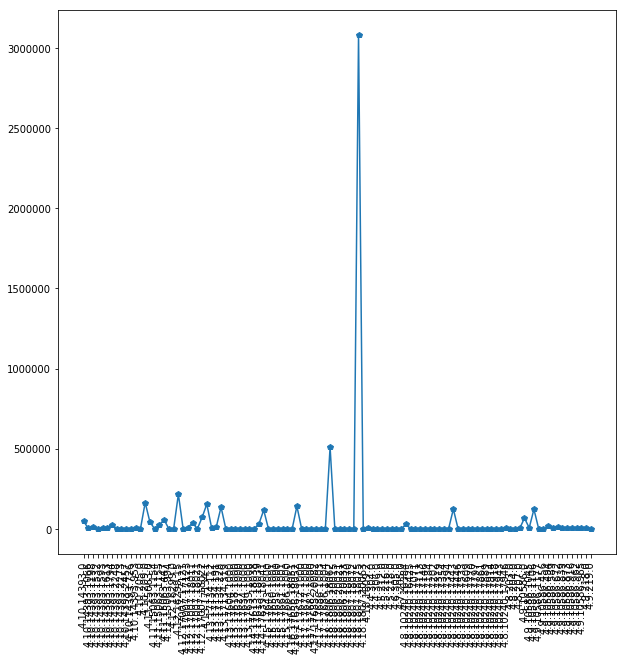

In [30]:
#histogram of value counts
value_counts = train['AppVersion'].value_counts()

plt.figure(figsize=(10,10))
plt.hist(value_counts)

plt.figure(figsize=(10,10))
plt.hist(value_counts[1:])

plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.plot(value_counts.sort_index(), 'p-')
#plt.yscale('log')
#plt.title("NOTE LOG SCALE")

In [89]:
#Mutual information scan to find best # of value counts to combine
#should also parallelize this piece

def find_mi_threshold(train, colname, n_low = 1, n_high = None):
    '''Since we'll only use this for categorical variables, cast to strings
    '''
    value_counts = train[colname].value_counts()
    value_counts.index = [str(i) for i in value_counts.index]

    if n_high is None:
        n_high = len(value_counts)
    
    train_df_orig = train[[colname]].copy() #contains only 1 col
    train_df_orig[colname] = train_df_orig[colname].astype(str) #contains only 1 col
    
    mi_values = {}
    for i in range(n_low, n_high+1): #can be made smarter
        top_values= list(value_counts[0:i].index)

        train_df = train_df_orig.copy() #contains only 1 col
        train_df[~train_df[colname].isin(top_values)] = 'rest'

        mi_values[i] = mutual_info_score(train_df[colname], train['HasDetections'])
        
    return mi_values

import multiprocessing as mp

def find_mi_threshold_parallel(train, colname, n_low = 1, n_high = None, n_jobs=1):
    '''Since we'll only use this for categorical variables, cast to strings
    '''
    
    values = train[colname].astype(str).fillna('null')
    
    value_counts = values.value_counts()

    if n_high is None:
        n_high = len(value_counts)
    
    train_df_orig = pd.DataFrame(values)
    
    manager = mp.Manager()
    mi_values = manager.dict()

    def calc_mi(value_counts, train_df_orig, colname, mi_values, i):
        top_values= list(value_counts[0:i].index)

        train_df = train_df_orig.copy()
        train_df[~train_df[colname].isin(top_values)] = 'rest'

        mi_values[i] = mutual_info_score(train_df[colname], train['HasDetections'])
    
    proc_list = []
    counter = 0
    for i in range(n_low, n_high+1): #can be made smarter
        proc = mp.Process(target=calc_mi, args=(value_counts, train_df_orig, colname, mi_values, i))
        proc.start()
        proc_list.append(proc)
        counter += 1
        
        if counter % n_jobs == 0:
            [p.join() for p in proc_list]
            proc_list = []
            
    [p.join() for p in proc_list]
        
    mi_values = dict(mi_values)
    
    return mi_values

In [32]:
colname = 'AppVersion'

In [33]:
%time mi_values = find_mi_threshold(train, colname, n_low=1, n_high=20)

CPU times: user 1min 18s, sys: 18.5 ms, total: 1min 18s
Wall time: 1min 18s


In [34]:
%time mi_values_parallel = find_mi_threshold_parallel(train, colname, n_low=1, n_high=20, n_jobs=10)

CPU times: user 601 ms, sys: 1.91 s, total: 2.51 s
Wall time: 17.5 s


In [35]:
sorted(mi_values.items(), key=operator.itemgetter(1), reverse=True)

[(20, 0.005644390057808235),
 (19, 0.005643893860430963),
 (18, 0.0056263211083099444),
 (17, 0.005626320019000791),
 (16, 0.0053863507115343955),
 (15, 0.0053785454577393275),
 (14, 0.005206604727880683),
 (13, 0.005146118799000548),
 (12, 0.005144636961380383),
 (11, 0.005109771504196808),
 (10, 0.005025473586054256),
 (9, 0.004134238891291671),
 (8, 0.004134238891174646),
 (7, 0.0040638331632995225),
 (6, 0.004041249972171201),
 (5, 0.003313855262312239),
 (4, 0.0029174057031849804),
 (3, 0.0027182944930465996),
 (2, 0.0027141325646495296),
 (1, 0.002528668794390343)]

In [36]:
sorted(mi_values_parallel.items(), key=operator.itemgetter(1), reverse=True)

[(20, 0.005644390057808235),
 (19, 0.005643893860430963),
 (18, 0.0056263211083099444),
 (17, 0.005626320019000791),
 (16, 0.0053863507115343955),
 (15, 0.0053785454577393275),
 (14, 0.005206604727880683),
 (13, 0.005146118799000548),
 (12, 0.005144636961380383),
 (11, 0.005109771504196808),
 (10, 0.005025473586054256),
 (9, 0.004134238891291671),
 (8, 0.004134238891174646),
 (7, 0.0040638331632995225),
 (6, 0.004041249972171201),
 (5, 0.003313855262312239),
 (4, 0.0029174057031849804),
 (3, 0.0027182944930465996),
 (2, 0.0027141325646495296),
 (1, 0.002528668794390343)]

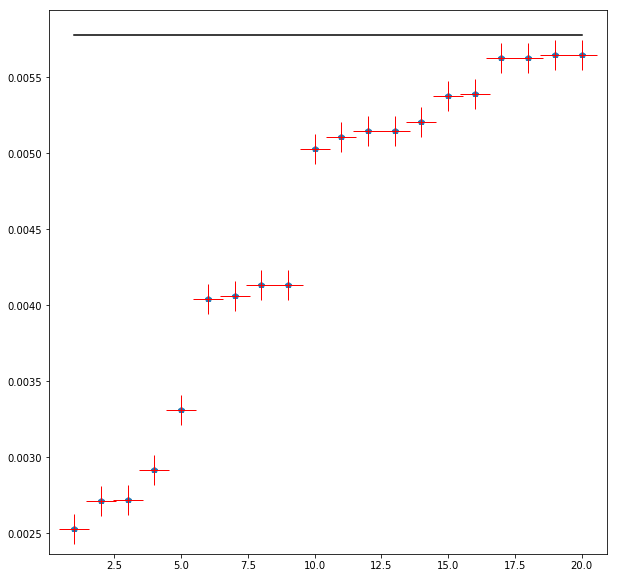

In [40]:
plt.figure(figsize=(10,10))
plt.plot(mi_values.keys(), mi_values.values(), 'p')
plt.plot(mi_values_parallel.keys(), mi_values_parallel.values(), 'p', color='r', marker='+', markersize=30)
plt.plot(mi_values.keys(), [mutual_info_score(train[colname], train['HasDetections'])]*len(mi_values), color='black')

As before we see some saturation once we pick the top 16 values for AppVersion and combine the rest.

In [74]:
assert(colname=='AppVersion')

train_df = train[[colname]].copy()
test_df = test[[colname]].copy()

top_values = list(value_counts[0:17].index)

train_df[~train_df[colname].isin(top_values)] = 'rest'
test_df[~test_df[colname].isin(top_values)] = 'rest'

train_df = pd.get_dummies(train_df[[colname]], dummy_na=True)
test_df = pd.get_dummies(test_df[[colname]], dummy_na=True)

In [75]:
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'col = {col} : train_score = {train_score} : test_score = {test_score}')

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


col = HasDetections : train_score = 0.5466199482548613 : test_score = 0.5468941375346532


At this stage, this might seem trivial. After all, we are doing only slightly better than random (AUC=0.5). But as before, this is just with one feature - AppVersion!

## Aside: Models with multiple features

Let's take a small detour now that we have explored two columns - EngineVersion (AUC = 0.56) and AppVersion (AUC = 0.54).

Ideally, we would like to build a model that uses both values and see how well it does. Let's try that now!

In [16]:
#Function to create appropriate dataframe

def create_one_hot(train, test, colnames, thresholds):
    assert(len(colnames)==len(thresholds))
    
    train_df = train[colnames].astype(str).copy()
    test_df = test[colnames].astype(str).copy()

    train_list, test_list = [], []
    for index, col in enumerate(colnames):
        value_counts = train[col].value_counts()
        value_counts.index = [str(i) for i in value_counts.index]
        
        top_values = list(value_counts[0:thresholds[index]].index)
        
        train_df[~train_df[col].isin(top_values)] = f'rest_{col}'
        test_df[~test_df[col].isin(top_values)] = f'rest_{col}'
        
        train_list.append( pd.get_dummies(train_df[[col]], dummy_na=True) )
        test_list.append( pd.get_dummies(test_df[[col]], dummy_na=True) )

    train_df = pd.concat(train_list, axis=1)
    test_df = pd.concat(test_list, axis=1)
    
    return train_df, test_df

In [77]:
train_df, test_df = create_one_hot(train, test, ['EngineVersion', 'AppVersion'], [11, 17])

In [78]:
print(train_df.shape)
print(test_df.shape)

(5352889, 32)
(3568594, 32)


In [79]:
for col in train_df:
    print(col)

EngineVersion_1.1.13504.0
EngineVersion_1.1.14104.0
EngineVersion_1.1.14600.4
EngineVersion_1.1.14700.5
EngineVersion_1.1.14800.3
EngineVersion_1.1.14901.4
EngineVersion_1.1.15000.2
EngineVersion_1.1.15100.1
EngineVersion_1.1.15200.1
EngineVersion_1.1.15300.5
EngineVersion_1.1.15300.6
EngineVersion_rest_EngineVersion
EngineVersion_nan
AppVersion_4.10.14393.0
AppVersion_4.10.209.0
AppVersion_4.11.15063.0
AppVersion_4.11.15063.447
AppVersion_4.12.16299.15
AppVersion_4.12.17007.18011
AppVersion_4.12.17007.18022
AppVersion_4.13.17134.1
AppVersion_4.13.17134.228
AppVersion_4.14.17613.18039
AppVersion_4.14.17639.18041
AppVersion_4.16.17656.18052
AppVersion_4.18.1806.18062
AppVersion_4.18.1807.18075
AppVersion_4.8.10240.17443
AppVersion_4.9.10586.0
AppVersion_4.9.10586.1106
AppVersion_rest_AppVersion
AppVersion_nan


In [17]:
def build_model(model, train_df, test_df):
    '''Use train and test as global variables
    '''
    
    model.fit(train_df, train['HasDetections'])

    train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
    test_pred = model.predict_proba(test_df)[:,1]

    train_labels = train['HasDetections']
    test_labels = test['HasDetections']

    train_score = roc_auc_score(train_labels, train_pred)
    test_score = roc_auc_score(test_labels, test_pred)

    print(f'train_score = {train_score} : test_score = {test_score}')
    
    return model, train_score, test_score

In [83]:
model = RandomForestClassifier()

model,_,_ = build_model(model, train_df, test_df)

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.5799794166341901 : test_score = 0.5797880698806783


So combining the two variables into one model gave us a significant boost!

EngineVersion - AUC = ~0.560

AppVersion - AUC = ~0.545

Combine - AUC = ~0.580 (3% improvement over EngineVersion i.e. 0.560)

If EngineVersion and AppVersion were perfectly correlated (i.e. in 1-1 correspondence for categorical variables), we would see no improvement by combining them.

## End of Aside: Models with multiple features

# col = SmartScreen (MI = ??)

We have our machinery setup so as long as columns are categorical, we can just keep applying it

In [92]:
colname = 'SmartScreen'

value_counts = train[colname].fillna('null').value_counts()

print(len(value_counts))
value_counts

20


RequireAdmin    2590357
null            1906079
ExistsNotSet     627601
Off              111710
Warn              81089
Prompt            20777
Block             13489
off                 829
On                  422
&#x02;              257
&#x01;              186
on                   76
requireadmin          5
0                     3
OFF                   3
Promt                 2
Enabled               1
requireAdmin          1
warn                  1
prompt                1
Name: SmartScreen, dtype: int64

In [94]:
#Mutual information scan to find best # of value counts to combine

assert(colname=='SmartScreen')

mi_values = find_mi_threshold_parallel(train, colname, n_low=2, n_high=19, n_jobs=10)

In [95]:
sorted(mi_values.items(), key=operator.itemgetter(1), reverse=True)

[(19, 0.02816486570974574),
 (18, 0.02816460672915393),
 (17, 0.028164508978547904),
 (16, 0.028164445499168158),
 (15, 0.028164088767970316),
 (14, 0.028164067428353305),
 (13, 0.028164025288590563),
 (12, 0.028163894961473514),
 (11, 0.028163865455426797),
 (10, 0.028163767417102793),
 (9, 0.028163712583765033),
 (8, 0.02816356329695278),
 (7, 0.02816334169304785),
 (6, 0.02816020352160098),
 (5, 0.028152542231826228),
 (4, 0.02809142172023904),
 (3, 0.028017012534531663),
 (2, 0.021971304800856892)]

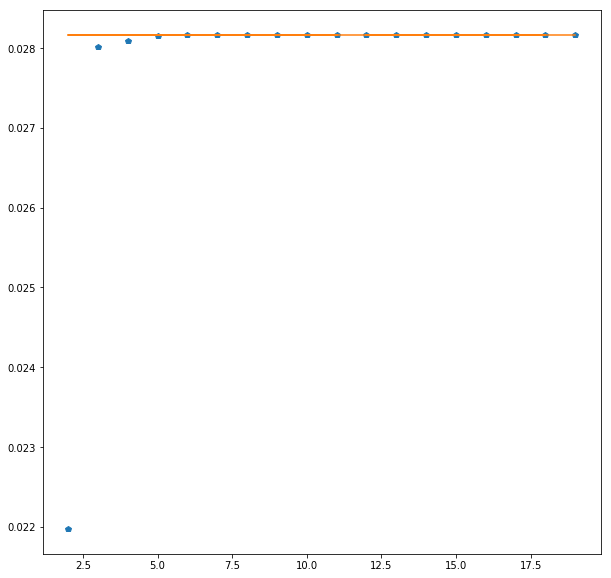

In [98]:
assert(colname=='SmartScreen')

plt.figure(figsize=(10,10))
plt.plot(mi_values.keys(), mi_values.values(), 'p')
plt.plot(mi_values.keys(), [mutual_info_score(train[colname].astype(str).fillna('null'), train['HasDetections'])]*len(mi_values))

In [102]:
train_df, test_df = create_one_hot(train, test, ['EngineVersion', 'AppVersion', 'SmartScreen'], [11, 17, 6])

In [103]:
model = RandomForestClassifier(n_jobs=10)
model,_,_ = build_model(model, train_df, test_df)

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.6356668891940039 : test_score = 0.6352146257795556


**AUC = 0.635**

### Notebooks vs modules

This is a highly opinionated comment. Notebooks are great for small examples to be shared but get unwieldy with large amounts of code. One major headache is the presence of global variables that might be initialized with the wrong values. For example, we often use "colname" above and have to insert assert statements to ensure we are always working with a single column.

In practice, I prefer using a simple text editor like sublime or emacs and ipython on the command line. At this stage in this project, I am putting in all functions in a utils.py file that we'll use from now on.

In [10]:
#Using utils functions
import utils

In [148]:
mi_values = utils.find_mi_threshold_parallel(train, 'AVProductStatesIdentifier', n_low=19650, n_high=19680, n_jobs=10)

In [6]:
utils.find_threshold(train, 'EngineVersion', 20, 0.2, debug=True)

mid_point=33 - shift=16 - values=[1 1 1]
mid_point=17 - shift=8 - values=[1 1 1]
mid_point=9 - shift=4 - values=[1 1 1]
mid_point=5 - shift=2 - values=[1 1 1]
mid_point=3 - shift=1 - values=[1 1 1]
mid_point=2 - shift=0 - values=[0 1 1]


2

In [11]:
model = utils.RandomForestClassifier(n_jobs=10)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.5756193233510761 : test_score = 0.5754134912203985


In [15]:
train_df = train[['AVProductStatesIdentifier']].fillna(0)
test_df = test[['AVProductStatesIdentifier']].fillna(0)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

train_score = 0.5943524148309816 : test_score = 0.5908466066484933


In [17]:
train_df, test_df = utils.create_one_hot(train, test, ['EngineVersion', 'AppVersion', 'SmartScreen'], [11, 17, 6])

In [18]:
train_df['AVProductStatesIdentifier'] = train['AVProductStatesIdentifier'].fillna(0)
test_df['AVProductStatesIdentifier'] = test['AVProductStatesIdentifier'].fillna(0)

In [20]:
model = utils.RandomForestClassifier(max_depth=20, n_jobs=10)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.6792199692282269 : test_score = 0.6719802078248494


In [21]:
train_df['Census_TotalPhysicalRAM'] = train['Census_TotalPhysicalRAM'].fillna(0)
test_df['Census_TotalPhysicalRAM'] = test['Census_TotalPhysicalRAM'].fillna(0)

In [22]:
model = utils.RandomForestClassifier(max_depth=20, n_jobs=10)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.6932177802521545 : test_score = 0.6823917578546365


In [23]:
train_df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = train['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(0)
test_df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = test['Census_InternalPrimaryDiagonalDisplaySizeInInches'].fillna(0)

In [25]:
model = utils.RandomForestClassifier(max_depth=15, n_jobs=10)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.6869614875904083 : test_score = 0.6828389138470167


In [28]:
train_df['Census_InternalBatteryNumberOfCharges'] = train['Census_InternalBatteryNumberOfCharges'].fillna(0)
test_df['Census_InternalBatteryNumberOfCharges'] = test['Census_InternalBatteryNumberOfCharges'].fillna(0)

In [29]:
model = utils.RandomForestClassifier(max_depth=15, n_jobs=10)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.686979994232052 : test_score = 0.6826652662069447


In [31]:
import astropy.stats as astv

In [37]:
hist, bin_edges = astv.histogram(train_df[train_df['Census_InternalBatteryNumberOfCharges']<1000]['Census_InternalBatteryNumberOfCharges'], bins='freedman')

/home/sanjay/.local/lib/python3.6/site-packages/astropy/stats/histogram.py:209: RuntimeWarning: divide by zero encountered in double_scalars
  Nbins = max(1, np.ceil((dmax - dmin) / dx))


ValueError: The inter-quartile range of the data is too small: failed to construct histogram with inf bins. Please use another bin method, such as bins="scott"

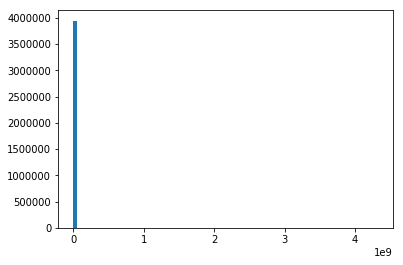

In [36]:
plt.hist(train_df[train_df['Census_InternalBatteryNumberOfCharges']<1000]['Census_InternalBatteryNumberOfCharges'], bins=bin_edges);

# Alternate Feature Engineering

So far we have worked with categorical variables where there's no notion of order or ranking. 

In [393]:
colname = 'DefaultBrowsersIdentifier'

train_df, test_df = create_one_hot(train, test, ['EngineVersion', 'AppVersion'], [11, 17])

In [410]:
train_df[colname] = train[colname].fillna(0).copy()
test_df[colname] = test[colname].fillna(0).copy()

In [418]:
model = RandomForestClassifier()
model,_,_ = build_model(model, train_df, test_df)

/usr/local/lib64/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train_score = 0.5831117936087538 : test_score = 0.5813819011837636


In [424]:
model = RandomForestClassifier(n_estimators=10, n_jobs=10, max_depth=18)
model, train_score, test_score = build_model(model, train_df, test_df)

train_score = 0.5818755252728536 : test_score = 0.5810634774092638


This is interesting! Not doing 1-hot encoding and treating this feature as an integer gives basically the same performance as doing the 1-hot encoding

## Adding counts to integer values

In [427]:
value_counts_dict = value_counts.to_dict()

In [429]:
value_counts_dict[0.0] = np.sum(train[colname].isnull())

In [432]:
train_df[f'counts_{colname}'] = train_df[colname].apply(lambda x: value_counts_dict[x])
test_df[f'counts_{colname}'] = test_df[colname].apply(lambda x: value_counts_dict[x])

KeyError: 398.0

In [431]:
train_df.iloc[0]

EngineVersion_1.1.13504.0                 0.0
EngineVersion_1.1.14104.0                 0.0
EngineVersion_1.1.14600.4                 0.0
EngineVersion_1.1.14700.5                 0.0
EngineVersion_1.1.14800.3                 0.0
EngineVersion_1.1.14901.4                 0.0
EngineVersion_1.1.15000.2                 0.0
EngineVersion_1.1.15100.1                 0.0
EngineVersion_1.1.15200.1                 1.0
EngineVersion_1.1.15300.5                 0.0
EngineVersion_1.1.15300.6                 0.0
EngineVersion_rest_EngineVersion          0.0
EngineVersion_nan                         0.0
AppVersion_4.10.14393.0                   0.0
AppVersion_4.10.209.0                     0.0
AppVersion_4.11.15063.0                   0.0
AppVersion_4.11.15063.447                 0.0
AppVersion_4.12.16299.15                  0.0
AppVersion_4.12.17007.18011               0.0
AppVersion_4.12.17007.18022               0.0
AppVersion_4.13.17134.1                   0.0
AppVersion_4.13.17134.228         

# Combining all features

## Aside: Different modeling techniques

Let's take a second detour before continuing on with our exploration of all the other columns. We have only tried one modeling technique - Random Forests - till now. While they are flexible, we should either try random forests with different parameters or even other techniques.

### Exploring Random Forests

(This is a cursory introduction - for more details, see slides)

Random forests are groups (hence the forest) of decision trees. A decision tree is essentially a sequence of if-else statements that will give us relatively pure (either HasDetections = 1 mostly or HasDetections = 0 mostly) at the end of each branch sequence.

Instead of writing the if-else blocks by hand, we learn them in a decision tree. For each if-else block, we need two quantities - what variable to make a decision on and what the threshold should be to decide between the if and else block. 

A decision tree solves this conundrum in the simplest possible way - greedily. In other words, it loops through every feature/column/variable, and for each one, tries every possible threshold amongs the value the data actually takes and looks at the purity of the sample after the decision. The purity is simply a measure of how many 1s vs 0s the target has before and after the cut. For example, if before the cut, the data has 50% 1s and 50% 0s (like our dataset) and after making a cut, the if-statement gives all 1s and else-statement gives all 0s, then we are done. We have a perfect model. In practice, the algorithm chooses the variable and cut which gives the highest increase in purity.

Purity can be measured several ways but one common measure is Gini which for our case would be:

$p(1-p)$

where p = probability (%) of rows that are labeled HasDetections=1.

Another measure of purity is entropy, defined as:

$S = -\Sigma_{i \in \text{categories}} p_i \log(p_i)$

These metrics would be averaged over the if-block and the else-block.

INSERT MATERIAL ABOUT RANDOM FORESTS

In [252]:
model1 = RandomForestClassifier(n_estimators=10, criterion='gini', n_jobs=10)
model1 = build_model(model1, train_df, test_df)

train_score = 0.5799810002538657 : test_score = 0.5798017205044155


In [258]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression() #don't worry about normalization right now
model2 = build_model(model2, train_df, test_df)

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train_score = 0.5762359969662515 : test_score = 0.5760858424562645


So we have two models - using completely different techniques and each gives roughly similar AUCs.

What if we just average their predictions?

In [261]:
model1_train_pred = model1.predict_proba(train_df)[:, 1]
model1_test_pred = model1.predict_proba(test_df)[:, 1]

model2_train_pred = model2.predict_proba(train_df)[:, 1]
model2_test_pred = model2.predict_proba(test_df)[:, 1]

mean_train_pred = (model1_train_pred + model2_train_pred) / 2.
mean_test_pred = (model1_test_pred + model2_test_pred) / 2.

In [262]:
train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, mean_train_pred)
test_score = roc_auc_score(test_labels, mean_test_pred)

print(f'train_score = {train_score} : test_score = {test_score}')

train_score = 0.578786978514533 : test_score = 0.5786191254267733


### More topics

Probability calibration

CV calibration with leaderboard

Ensembling

Interpretation

Notes about kaggle vs real life